# Idea 1
- We induce subgraph of proteins (or maybe subgraph of proteins + 1 degree of separation away)
- Find communities using MCL or Louvain to get us communities of size ~30
- Determine if these communities are functional
- Find bottlenecks/hub proteins of each complex
- This gives us relevant proteins for treatment or disrupting pathways

In [2]:
import networkx as nx
import numpy as np
import scipy as sp
import pandas as pd

In [3]:
# Reading in graph 
G = nx.read_weighted_edgelist("yeast.txt",comments="#",nodetype=str)

Removing edges not meeting threshold score. **Need to decide what we are doing with essential nodes.**

In [4]:
# Deleting edges that don't meet threshold score
threshold_score = 700
for edge in G.edges: 
    weight = list(G.get_edge_data(edge[0],edge[1]).values())
    if(weight[0] <= threshold_score):
        G.remove_edge(edge[0],edge[1])

Relabelling nodes to get rid of 4932 tag

In [5]:
H = nx.relabel_nodes(G, lambda x: x[5:])

Getting list of all yeast homologs

In [6]:
df = pd.read_csv("human_to_yeast.csv")
homologs = list(set(list(df["homolog_systematic_name"])))

Getting subgraph induced by yeast homologs

In [7]:
H0 = H.subgraph(homologs).copy()

In [8]:
print(H0)

Graph with 783 nodes and 4518 edges


Louvain

In [9]:
louvain = nx.algorithms.community.louvain_communities(H0, resolution=7, seed=123)
louvain.sort(key=len, reverse=True)

number_of_communities = len(louvain)
size_of_communities = [len(community) for community in louvain]

print("Number of communities: {}".format(number_of_communities))
print("Sizes of communities: ", size_of_communities)

Number of communities: 102
Sizes of communities:  [32, 32, 26, 24, 23, 23, 23, 21, 21, 21, 21, 21, 20, 20, 19, 19, 19, 18, 18, 18, 17, 17, 16, 16, 16, 16, 15, 15, 15, 13, 13, 12, 11, 11, 11, 11, 10, 8, 8, 7, 6, 4, 4, 4, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Drawing communities (taking the t biggest communities)

In [10]:
import matplotlib.pyplot as plt
from netgraph import Graph
import random

c:\Users\amool\anaconda3\lib\site-packages\netgraph\_edge_layout.py:785: RuntimeWarning: invalid value encountered in true_divide
  displacement = compatibility * delta / distance_squared[..., None]


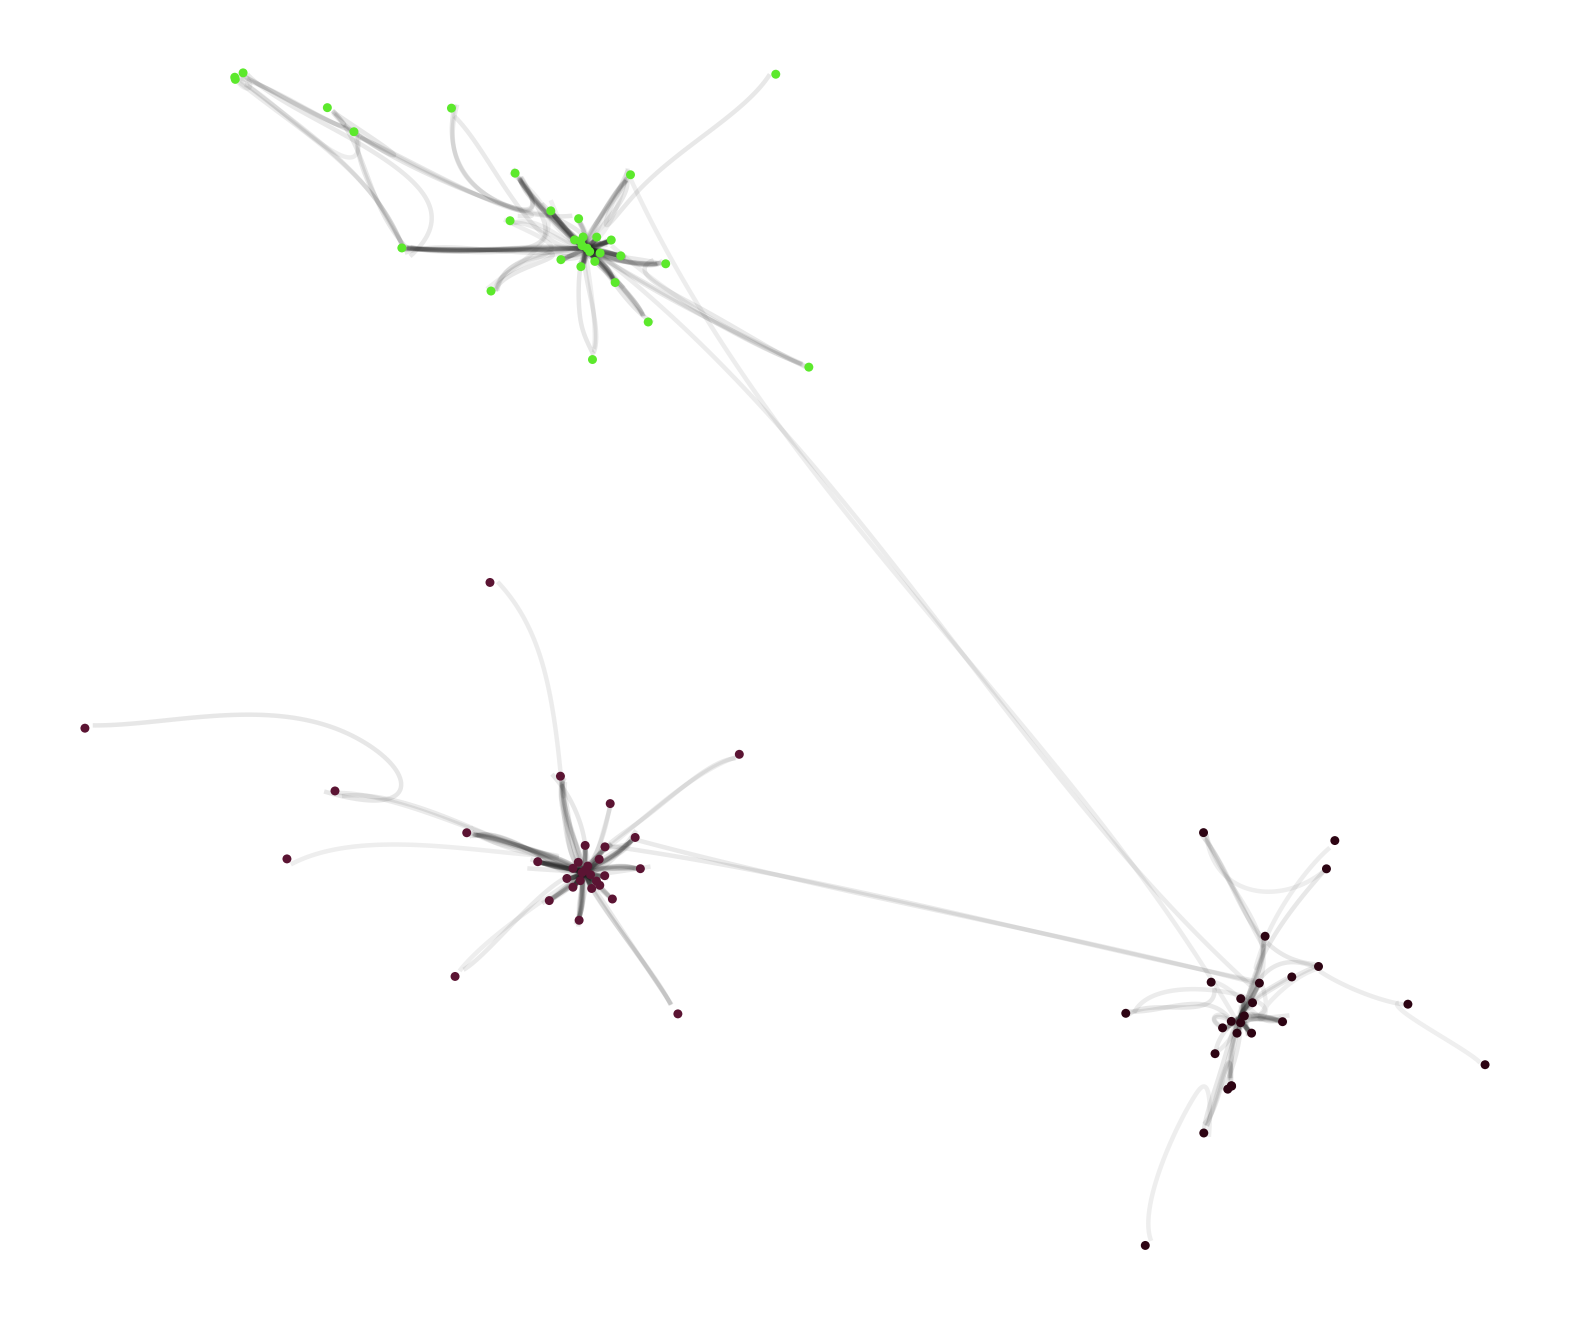

In [11]:
# parameter that controls how many communities we are interested in
t = 3

# Generating list of nodes of first t communities
nodes = []
for i in range(t):
  nodes.extend(louvain[i]) 


# Subgraph induced by these communities
H1 = H0.subgraph(nodes).copy()

# Dictionary where key is node and value is community index
node_to_community = {}
for i in range(t):
  for node in louvain[i]:
    node_to_community[node] = i

# Assigning t random colours each of our communities
community_to_color = dict([(i, "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])) for i in range(t)])
node_color = {node: community_to_color[community_id] for node, community_id in node_to_community.items()}

plt.figure(figsize=(20,20))
Graph(H1,
      node_color=node_color, node_edge_width=0, edge_alpha=0.1, node_size = 0.5, edge_width = 0.5,
      node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_community),
      edge_layout='bundled', edge_layout_kwargs=dict(k=2000)
)

plt.show()

## Centrality

The sections below find the most central protein in each community, where each entry in the list is {community_index: (protein, centrality_value)}.

Degree Centrality

In [12]:
hub = {}
for index, community in enumerate(louvain):
  sub = H0.subgraph(community).copy()
  d = sorted(list(nx.algorithms.centrality.degree_centrality(sub).items()), key=lambda x: x[1], reverse=True)
  hub[index] = d[0]

print(hub)

{0: ('YMR105C', 0.6129032258064516), 1: ('YFL038C', 0.6451612903225806), 2: ('YBL016W', 0.52), 3: ('YER125W', 0.5217391304347826), 4: ('YBL003C', 0.8181818181818182), 5: ('YBR247C', 0.8636363636363636), 6: ('YML001W', 0.6818181818181819), 7: ('YKL145W', 1.0), 8: ('YDL188C', 0.5), 9: ('YKL003C', 0.8), 10: ('YIL061C', 0.8), 11: ('YMR165C', 0.30000000000000004), 12: ('YNL189W', 0.631578947368421), 13: ('YGR167W', 0.6842105263157894), 14: ('YDR091C', 0.5555555555555556), 15: ('YLR229C', 0.7777777777777777), 16: ('YJL034W', 0.611111111111111), 17: ('YML032C', 0.8235294117647058), 18: ('YHR143W-A', 0.7647058823529411), 19: ('YPR135W', 1.0), 20: ('YPL106C', 1.0), 21: ('YHR090C', 0.6875), 22: ('YDL029W', 0.9333333333333333), 23: ('YLR180W', 0.3333333333333333), 24: ('YPR183W', 0.4666666666666667), 25: ('YOL133W', 0.9333333333333333), 26: ('YER069W', 0.6428571428571428), 27: ('YLR043C', 0.5714285714285714), 28: ('YDL192W', 0.7857142857142857), 29: ('YER016W', 0.75), 30: ('YCR027C', 0.75), 31: (

Eigenvector Centrality

In [13]:
hub = {}
for index, community in enumerate(louvain):
  sub = H0.subgraph(community).copy()
  d = sorted(list(nx.algorithms.centrality.eigenvector_centrality(sub).items()), key=lambda x: x[1], reverse=True)
  hub[index] = d[0]

print(hub)

{0: ('YCR012W', 0.28874545546561714), 1: ('YLR268W', 0.3014733362767276), 2: ('YBL016W', 0.37141282320340774), 3: ('YER125W', 0.4230585591384346), 4: ('YBL003C', 0.29750372588914503), 5: ('YBR247C', 0.29749756901769514), 6: ('YML001W', 0.3961176041622018), 7: ('YKL145W', 0.23132194958651595), 8: ('YJR064W', 0.3603697124031755), 9: ('YKL003C', 0.29226681565015095), 10: ('YIL061C', 0.29236104388876016), 11: ('YDL052C', 0.4400285923464754), 12: ('YNL189W', 0.3332579688615804), 13: ('YGR167W', 0.34266169782209593), 14: ('YHR020W', 0.36234826516816254), 15: ('YLR229C', 0.3631297637737733), 16: ('YLR378C', 0.45325848310425343), 17: ('YML032C', 0.3647123393531636), 18: ('YHR143W-A', 0.36860136020172574), 19: ('YPR135W', 0.30051052168602643), 20: ('YPL106C', 0.28441851956693404), 21: ('YHR090C', 0.35780103896563104), 22: ('YDL029W', 0.3331702804140162), 23: ('YLR180W', 0.46575103033758275), 24: ('YPR183W', 0.4947576240135439), 25: ('YOL133W', 0.3813739430907457), 26: ('YER069W', 0.463382964810

Betweenness Centrality

In [14]:
hub = {}
for index, community in enumerate(louvain):
  sub = H0.subgraph(community).copy()
  d = sorted(list(nx.algorithms.centrality.betweenness_centrality(sub).items()), key=lambda x: x[1], reverse=True)
  hub[index] = d[0]

print(hub)

{0: ('YMR105C', 0.23356708310867902), 1: ('YFL038C', 0.18252710600674915), 2: ('YBL016W', 0.34624470899470894), 3: ('YER125W', 0.3975719932241672), 4: ('YIL126W', 0.11798052554355075), 5: ('YJL069C', 0.14780629423486566), 6: ('YML001W', 0.2607081951237795), 7: ('YKL145W', 0.018224728487886387), 8: ('YDL188C', 0.2657894736842105), 9: ('YLL013C', 0.24880952380952379), 10: ('YBR257W', 0.09999999999999999), 11: ('YMR165C', 0.3973684210526316), 12: ('YDR510W', 0.23883783532906339), 13: ('YNL106C', 0.1870776478232618), 14: ('YDR091C', 0.21668222844693433), 15: ('YHL007C', 0.13694366635543107), 16: ('YLR378C', 0.34220354808590103), 17: ('YML032C', 0.12700438018344595), 18: ('YHR143W-A', 0.2150075414781297), 19: ('YPR135W', 0.05968720821661998), 20: ('YPL106C', 0.03031445406445406), 21: ('YPL235W', 0.15710317460317458), 22: ('YLL050C', 0.1040740740740741), 23: ('YGL202W', 0.5984126984126984), 24: ('YPR183W', 0.526984126984127), 25: ('YOL133W', 0.14650793650793653), 26: ('YER069W', 0.4761904761

VoteRank

In [15]:
print(nx.algorithms.centrality.voterank(H0, 10))

['YFL039C', 'YBR160W', 'YFL005W', 'YNL031C', 'YDL126C', 'YPL240C', 'YJL034W', 'YBR010W', 'YLR229C', 'YJL194W']


Creating graph of where each community is a node and the weight of edges between two communities A and B is equal to the number of communities between A and B.

In [16]:
# Going through all communities and setting the node attribute to be the index of the community it is in
community_dict = {}
for index, community in enumerate(louvain):
  for node in community:
    community_dict[node] = index

nx.set_node_attributes(H0, community_dict, "community")


# Creating basic graph with all our communities as nodes, but no edges yet
F = nx.Graph()
F.add_nodes_from(range(0, number_of_communities))

for (u, v) in H0.edges:
  community_i = H0.nodes[u]["community"]
  community_j = H0.nodes[v]["community"]
  
  # if in different communities
  if community_i != community_j:
    
    # if community graph doesnt already have edge, we have to add the edge
    if not F.has_edge(community_i, community_j):
      F.add_edge(community_i, community_j, weight = 1)
    else:
      F[community_i][community_j]["weight"] += 1

Finding max weight (min weight is trivially 1)

In [17]:
max_weight = 1
for edge in F.edges:
  if F.edges[edge]["weight"] > max_weight:
    max_weight = F.edges[edge]["weight"]

print(max_weight)

63


Betweenness Centrality

Output below tells us that community 26 has the highest betweenness centrality (so it could be involved in many interactions etc.)

In [18]:
d = list(nx.algorithms.centrality.betweenness_centrality(F).items())
print(sorted(d, reverse=True, key=lambda x: x[1]))

[(6, 0.011801460859575367), (27, 0.0070218229217324036), (0, 0.006816374547255747), (4, 0.006295034039369146), (17, 0.005930313205438665), (20, 0.005851434763049703), (35, 0.00583324816497027), (12, 0.0058193635008753795), (29, 0.005241673770286412), (3, 0.004528905718626162), (9, 0.004303453527649921), (76, 0.004073600027148833), (8, 0.00394054781238544), (11, 0.0032128041439276915), (25, 0.0032120866171117084), (32, 0.0030150281570032835), (16, 0.002981643219266982), (7, 0.0029032919667747853), (18, 0.0028629871526707224), (44, 0.002833328885415229), (14, 0.0026905703428489274), (37, 0.002504494342944877), (15, 0.0024114102694475434), (30, 0.002406057392913684), (40, 0.002305272356981296), (1, 0.0022425007044983747), (2, 0.002088240603642587), (5, 0.0019577783007865748), (13, 0.0017366631959143584), (31, 0.0017175810987692176), (21, 0.0017075515204012838), (10, 0.0017024011485899456), (38, 0.0016057292163885555), (36, 0.0015037674473453667), (22, 0.001243792180619559), (19, 0.0012109

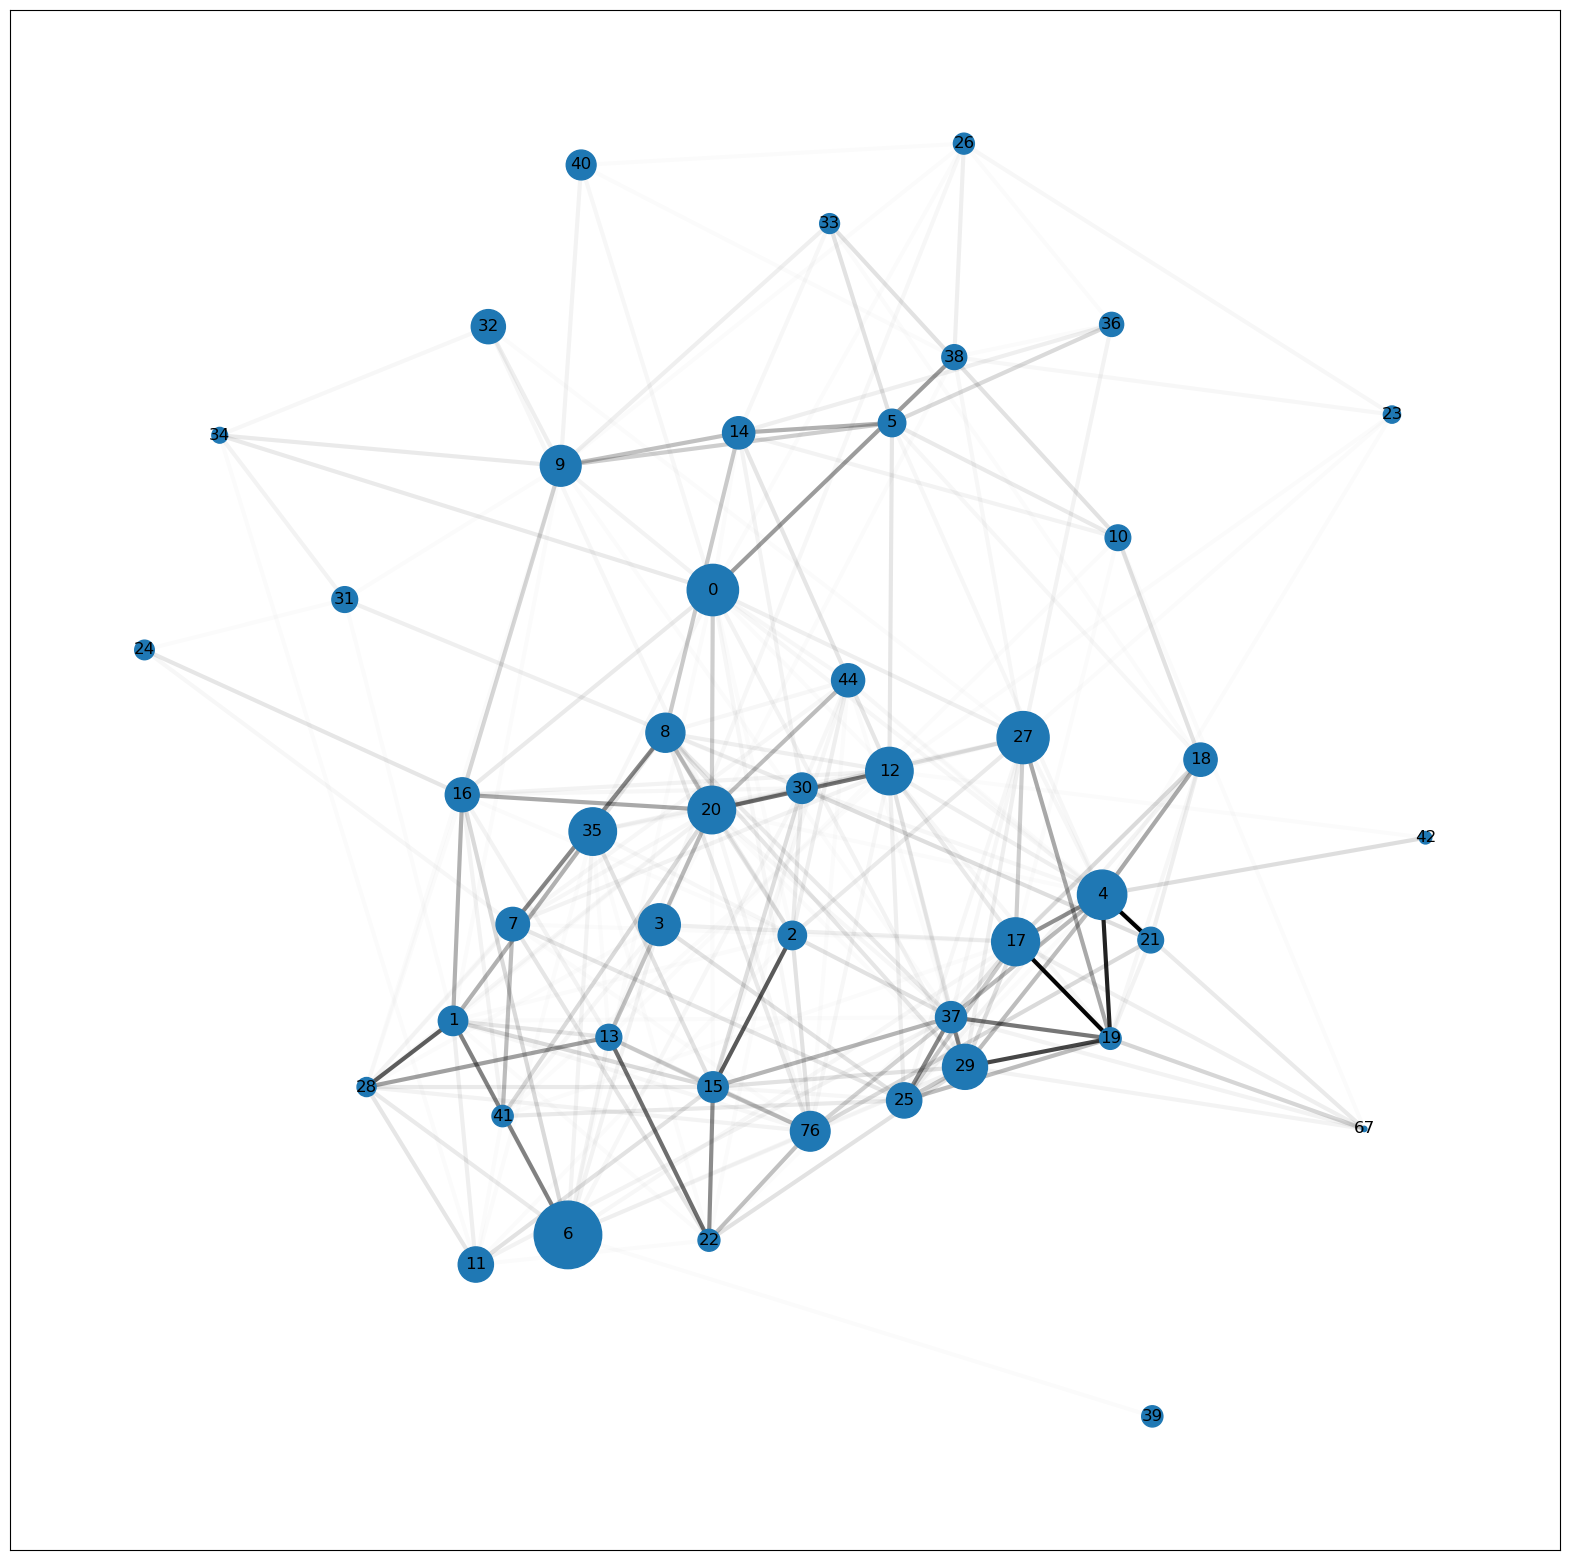

In [19]:
# Relating node sizes in the plot to how central the communities are (i.e. how large their betweenness centrality is).
# Note that communities with zero centrality disappear from the plot (aka communities which are not connected)
node_size = []
for i in range(len(d)):
  if d[i][1] != 0:
    node_size.append(d[i][1] * 200000)
nodelist = [node for (node, c) in d if c != 0]

# Relating edge opacity to weight.
edgelist = [(u, v) for (u, v) in F.edges if u in nodelist and v in nodelist]
edge_color = []
for edge in edgelist:
  # We normalise weight value so that it becomes between 0-1 for alpha values in RGBA
  edge_color.append((0, 0, 0, (F.edges[edge]["weight"] - 1) / (max_weight - 1)))

# Adding weight labels (bc why not, this is easily removed)
labels = nx.get_edge_attributes(F,'weight')

# Scaling node labels with node sizes


plt.figure(figsize=(20,20))
pos=nx.spring_layout(F)
nx.draw_networkx(F, pos, nodelist=nodelist, edgelist=edgelist, node_size=node_size, edge_color=edge_color, width=3)

# Adding weight labels (bc why not, this is easily removed)
# labels = nx.get_edge_attributes(F,'weight')
# nx.draw_networkx_edge_labels(F, pos, edge_labels=labels, font_size=5)

# TODO Scaling node labels with node size

plt.show()